In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoModel, AutoTokenizer, DebertaModel, DebertaV2Model, DebertaTokenizer, DebertaForSequenceClassification, AutoModelForSequenceClassification
import numpy as np

In [3]:
print(torch.cuda.is_available())
torch.cuda.set_device(0)
device = torch.device("cuda")

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


True


In [4]:
path_data = "/content/"
path_train = path_data + "train.jsonl"
path_validation = path_data + "validation.jsonl"

train = pd.read_json(path_or_buf=path_train, lines=True)
validation = pd.read_json(path_or_buf=path_validation, lines = True)

In [5]:
columns_to_drop = ["uuid", "postId", "postPlatform", "targetDescription", "targetKeywords", "targetMedia", "targetUrl", "provenance", "spoiler", "spoilerPositions"]
train = train.drop(columns=columns_to_drop)#delete not needed columns
validation = validation.drop(columns=columns_to_drop)

In [6]:
def delete_brackets(dataframe, columns_with_brackets):
    for index, data_row in dataframe.iterrows():
        for column_name in columns_with_brackets:
            data_row[column_name] = data_row[column_name][0]

    return dataframe
columns_with_brackets = ["postText", "targetParagraphs", "tags"]

train = delete_brackets(train, columns_with_brackets)
validation = delete_brackets(validation, columns_with_brackets)

In [7]:
def one_hot_tags(dataframe):
    tags_dummies = pd.get_dummies(dataframe.tags)
    dataframe = dataframe.drop(columns=["tags"])
    dataframe = pd.concat([dataframe, tags_dummies], axis=1)
    return dataframe
train = one_hot_tags(train)
validation = one_hot_tags(validation)

934


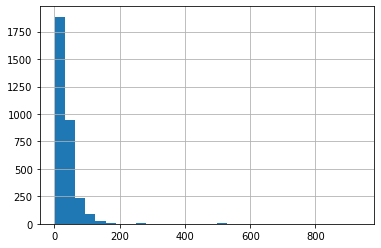

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train.targetParagraphs]
print(max(seq_len))

pd.Series(seq_len).hist(bins = 30)
# 28 33

In [9]:
model_name = "microsoft/deberta-base"
#model_name = "bert-base-uncased"
#model_name = "microsoft/deberta-base"
#debert = DebertaModel.from_pretrained(model_name)
debert =DebertaForSequenceClassification.from_pretrained(model_name, num_labels = 3)

#tokenizer = DebertaTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [10]:
tokens_train_post = tokenizer.batch_encode_plus(
    train.postText.tolist(),
    max_length = 28,
    pad_to_max_length=True,
    truncation=True
)
tokens_train_title = tokenizer.batch_encode_plus(
    train.targetTitle.tolist(),
    max_length = 33,
    pad_to_max_length=True,
    truncation=True
)

tokens_train_par = tokenizer.batch_encode_plus(
    train.targetParagraphs.tolist(),
    max_length = 512-28-33,
    pad_to_max_length=True,
    truncation=True
)

tokens_validation_post = tokenizer.batch_encode_plus(
    validation.postText.tolist(),
    max_length = 28,
    pad_to_max_length=True,
    truncation=True
)
tokens_validation_title = tokenizer.batch_encode_plus(
    validation.targetTitle.tolist(),
    max_length = 33,
    pad_to_max_length=True,
    truncation=True
)

tokens_validation_par = tokenizer.batch_encode_plus(
    validation.targetParagraphs.tolist(),
    max_length = 512-28-33,
    pad_to_max_length=True,
    truncation=True
)




tokens_train_post

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [[1, 771, 293, 15565, 5029, 33149, 18171, 590, 1560, 5333, 6, 125, 4314, 8886, 7301, 11238, 28795, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 34665, 3880, 1248, 13, 455, 2752, 9, 34011, 4683, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 713, 16, 99, 817, 1321, 1372, 480, 8, 24, 18, 45, 49, 24288, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 510, 22947, 16, 81, 8358, 93, 50141, 406, 173, 10095, 47, 240, 1386, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 133, 1969, 169, 7, 7142, 7666, 98, 14, 24, 18, 6683, 33564, 8, 37603, 13593, 7, 5, 5730, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2264, 2594, 114, 110, 92, 1754, 510, 20529, 120, 685, 50, 3579, 6, 40, 1257, 109, 932, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 133, 31613, 2612, 272, 15313, 11596, 7776, 305, 12541, 8640, 7949, 13758, 324, 16652, 6806, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1185, 17, 27, 890, 9154, 28305, 653, 152, 3664, 17765, 11, 5, 3601, 13149, 2667, 446, 11, 12587, 4, 2, 0, 0, 0, 0, 0, 0, 0], [1, 31231, 47

In [11]:

def prepare_tokens(post, title, paragraphs):
  result = {'input_ids': [], 'attention_mask': []}
  for i in range(len(post["input_ids"])):
      post_data = post['input_ids'][i]
      post_mask = post['attention_mask'][i]
      title_data = title['input_ids'][i]
      title_mask = title['attention_mask'][i]
      paragraphs_data = paragraphs['input_ids'][i]
      paragraphs_mask = paragraphs['attention_mask'][i]

      new_data = post_data + title_data + paragraphs_data
      new_mask = post_mask + title_mask + paragraphs_mask

      result['input_ids'].append(new_data)
      result['attention_mask'].append(new_mask)
  return result
tokens_train = prepare_tokens(tokens_train_post, tokens_train_title, tokens_train_par)
tokens_validation = prepare_tokens(tokens_validation_post, tokens_validation_title, tokens_validation_par)

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])

validation_seq = torch.tensor(tokens_validation['input_ids'])
validation_mask = torch.tensor(tokens_validation['attention_mask'])

train_labels = train.iloc[:, -3:]
train_y = torch.tensor(train_labels.values.tolist()).float()

validation_labels = validation.iloc[:, -3:]
validation_y = torch.tensor(validation_labels.values.tolist()).float()


In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 4

# wrap tensors
print(train_seq.shape, train_mask.shape, train_y.shape)
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(validation_seq, validation_mask, validation_y)

val_sampler = RandomSampler(val_data)

val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



torch.Size([3200, 512]) torch.Size([3200, 512]) torch.Size([3200, 3])


In [26]:
# pass the pre-trained BERT to our define architecture
model = debert#BERT_Arch(debert)

# push the model to GPU
model = model.to(device)
#model

In [15]:
# optimizer from hugging face transformers
from transformers import AdamW
#import torch.optim as optim

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)
#optimizer = optim.AdamW(model.parameters(), lr=0.001)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
cross_entropy  = nn.CrossEntropyLoss()


# number of training epochs
epochs = 10

In [17]:
model.train()

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    s = 0
    for step, batch  in enumerate(train_dataloader, 0):
        print("_", step, epoch)
        # get the inputs; data is a list of [inputs, labels]
        sent_id, mask, labels = batch
        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)
        # zero the parameter gradients
        model.zero_grad()

        # forward + backward + optimize
        preds = model(sent_id, attention_mask = mask, labels=labels)

        # compute the loss between actual and predicted values
        loss = preds[0]#cross_entropy(preds[0], labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        s+=1

    print('[%d/100] loss: %.8f' %
          (epoch+1 ,  running_loss / s))
    running_loss = 0.0

print('Finished Training')


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
_ 608 3
_ 609 3
_ 610 3
_ 611 3
_ 612 3
_ 613 3
_ 614 3
_ 615 3
_ 616 3
_ 617 3
_ 618 3
_ 619 3
_ 620 3
_ 621 3
_ 622 3
_ 623 3
_ 624 3
_ 625 3
_ 626 3
_ 627 3
_ 628 3
_ 629 3
_ 630 3
_ 631 3
_ 632 3
_ 633 3
_ 634 3
_ 635 3
_ 636 3
_ 637 3
_ 638 3
_ 639 3
_ 640 3
_ 641 3
_ 642 3
_ 643 3
_ 644 3
_ 645 3
_ 646 3
_ 647 3
_ 648 3
_ 649 3
_ 650 3
_ 651 3
_ 652 3
_ 653 3
_ 654 3
_ 655 3
_ 656 3
_ 657 3
_ 658 3
_ 659 3
_ 660 3
_ 661 3
_ 662 3
_ 663 3
_ 664 3
_ 665 3
_ 666 3
_ 667 3
_ 668 3
_ 669 3
_ 670 3
_ 671 3
_ 672 3
_ 673 3
_ 674 3
_ 675 3
_ 676 3
_ 677 3
_ 678 3
_ 679 3
_ 680 3
_ 681 3
_ 682 3
_ 683 3
_ 684 3
_ 685 3
_ 686 3
_ 687 3
_ 688 3
_ 689 3
_ 690 3
_ 691 3
_ 692 3
_ 693 3
_ 694 3
_ 695 3
_ 696 3
_ 697 3
_ 698 3
_ 699 3
_ 700 3
_ 701 3
_ 702 3
_ 703 3
_ 704 3
_ 705 3
_ 706 3
_ 707 3
_ 708 3
_ 709 3
_ 710 3
_ 711 3
_ 712 3
_ 713 3
_ 714 3
_ 715 3
_ 716 3
_ 717 3
_ 718 3
_ 719 3
_ 720 3
_ 721 3
_ 722 3
_ 723 3
_ 724 3

In [30]:
# get predictions for train data
model.eval()
with torch.no_grad():
    good = 0
    all = 0
    for step, batch  in enumerate(val_dataloader, 0):
        sent_id, mask, labels = batch
        preds = model(sent_id.to(device), mask.to(device))
        preds = np.argmax(preds.logits.cpu(), axis=1).tolist()
        labels = np.argmax(labels, axis=1).tolist()
        
        for i in range(len(preds)):
            if preds[i] == labels[i]:
                good +=1
            all +=1
        
        #preds = preds.detach().cpu().numpy()
good/all


0.69875

In [19]:
validation_y

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [21]:
model.save_pretrained("/content/model")

In [27]:
model = DebertaForSequenceClassification.from_pretrained("/content/model").to(device)